# ODE-Solvers from Scratch

All the other tutorials show how to use the ODE-solver with the `probsolve_ivp` function.
This is great, though `probnum` has more customisation to offer.

In [1]:
import probnum.diffeq as pnd
import probnum.filtsmooth as pnfs
import probnum.statespace as pnss
import probnum.random_variables as pnrv
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("../../probnum.mplstyle")

First we define the ODE problem. As always, we use Lotka-Volterra. It is important that `initrv` is an actual random variable. Arrays can be wrapped with `probnum.random_variables.Constant`. 

In [2]:
ivp = pnd.lotkavolterra([0.0, 20.0], initrv=pnrv.Constant(np.array([20.0, 20.0])))

Next, we define a prior distribution and a measurement model. The former allows any `Integrator`, which currently restricts the choice to `IBM`, `IOUP`, and `Matern`. 
The measurement model requires a choice between EK0, EK1 (extended Kalman filters of order 0 or 1, respectively) and UK (unscented Kalman filter). 
After this choice is made, each of those classes offer a constructor that defines the model directly from the initial value problem, e.g. `DiscreteUKFComponent.from_ode(ivp, prior, evlvar)`. `evlvar` is usually zero. The prior is the `Integrator` chosen above.  

In [3]:
prior = pnss.IBM(ordint=4, spatialdim=ivp.dimension, forward_implementation="sqrt", backward_implementation="sqrt")
ekf = pnfs.DiscreteEKFComponent.from_ode(ivp, prior, np.zeros((2, 2)), ek0_or_ek1=0,forward_implementation="sqrt", backward_implementation="sqrt")

Once this is done, we can initialise the Gaussian IVP filter.
One crucial decision that we have to make is the method if initialisation (the prior process tracks derivatives of the states, and the derivatives of the initial state must be inferred). 
The most reliable option (currently) is fitting the prior to a few steps of a RK solver which is used if the `GaussianIVPFilter` object is constructed from `from_scipy_init`. 
In `probsolve_ivp`, this would be done automatically.

In [4]:
solver = pnd.GaussianIVPFilter.construct_with_rk_init(ivp, prior, ekf, with_smoothing=True)

Now we can solve the ODE. To this end, define a `StepRule`, e.g. `ConstantSteps` or `AdaptiveSteps`. 

In [5]:
steprule = pnd.AdaptiveSteps(firststep=0.1, atol=1e-2, rtol=1e-2)
odesol = solver.solve(steprule=steprule)

`GaussianIVPFilter.solve` returns an `ODESolution` object, which is sliceable and callable. The latter can be used to plot the solution on a uniform grid, even though the solution was computed on an adaptive grid. Be careful: the return values of `__call__`, etc., are always random variable-like objects. We decide to plot the mean.

In [6]:
evalgrid = np.arange(ivp.t0, ivp.tmax, step=0.2)
sol = odesol(evalgrid)

y = sol.mean[:, 1]
s = sol.std[:, 1]

Et voila: this is the solution to the Lotka-Volterra model.

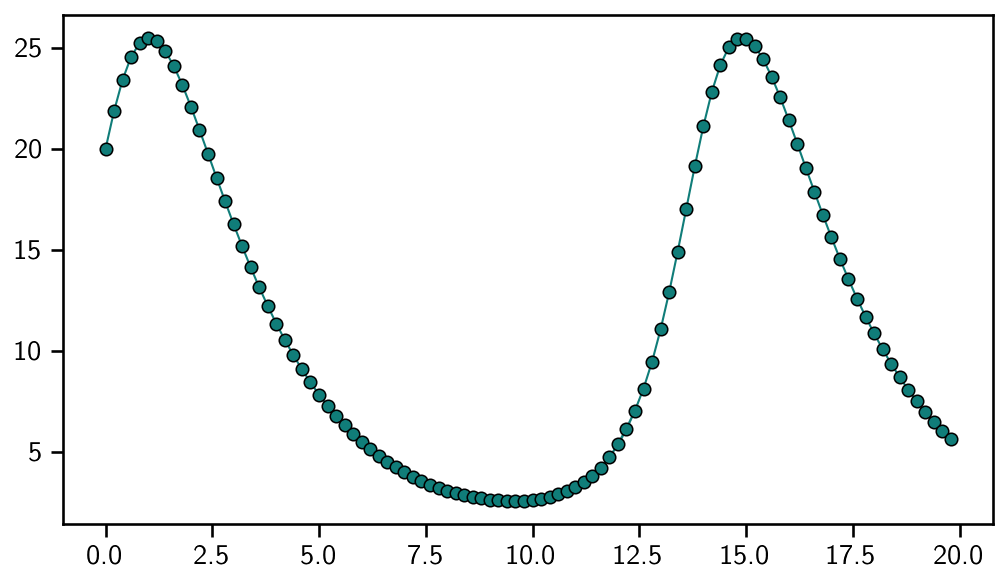

In [7]:
plt.plot(evalgrid, y, "o-", linewidth=1)
plt.fill_between(evalgrid, y-3*s, y+3*s, alpha=0.5)
plt.show()